In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras import models
from keras import layers
from keras import optimizers
from matplotlib import pyplot as plt
import tensorflow as tf

Using TensorFlow backend.
W1003 21:24:57.204160 140508733228672 __init__.py:308] Limited tf.compat.v2.summary API due to missing TensorBoard installation.


In [2]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [3]:
#Работа с данными - создаем генераторы, которые будет распаковывать, ресайзить и аугментировать 
#картинки для тренировочного, валидационного и тестового сетов

#Здесь определяется набор аугментаций 
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   zoom_range=0.4, #Изменение масштаба
                                   #horizontal_flip=True, 
                                   vertical_flip=True, 
                                   brightness_range=[0.1, 0.7], #Изменение яркости
                                   fill_mode='nearest') #Режим паддинга

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

TRAIN_DIR = '/home/iref/Datasets/Kern_project/train'
VAL_DIR = '/home/iref/Datasets/Kern_project/val'
TEST_DIR = '/home/iref/Datasets/Kern_project/test'

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(100, 100),
    batch_size=16,
    class_mode='binary')

validation_generator = train_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(100, 100),
    batch_size=8,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(100, 100),
    batch_size=7,
    class_mode='binary'
)

Found 957 images belonging to 2 classes.
Found 119 images belonging to 2 classes.
Found 107 images belonging to 2 classes.


In [17]:
#Создаем модель: арх-ра vgg16 с кастомным классификатором 
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(100, 100, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(1, activation='sigmoid')) #Выход - нейрон с сигмоидой в качестве функции активации

In [18]:
#Для начала обучим отдельно классификатор
conv_base.trainable = False

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=27,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=6,
    verbose=2
)

Epoch 1/50
 - 2s - loss: 1.6512 - acc: 0.6172 - val_loss: 1.2951 - val_acc: 0.6458
Epoch 2/50
 - 1s - loss: 1.6433 - acc: 0.6042 - val_loss: 0.5369 - val_acc: 0.7447
Epoch 3/50
 - 1s - loss: 1.5538 - acc: 0.6187 - val_loss: 0.6748 - val_acc: 0.7500
Epoch 4/50
 - 1s - loss: 1.2757 - acc: 0.6551 - val_loss: 0.6850 - val_acc: 0.7292
Epoch 5/50
 - 1s - loss: 1.2289 - acc: 0.6782 - val_loss: 0.8186 - val_acc: 0.8511
Epoch 6/50
 - 1s - loss: 0.9612 - acc: 0.7149 - val_loss: 0.6282 - val_acc: 0.7917
Epoch 7/50
 - 1s - loss: 0.9192 - acc: 0.7292 - val_loss: 0.7745 - val_acc: 0.6383
Epoch 8/50
 - 1s - loss: 0.9461 - acc: 0.7332 - val_loss: 0.7563 - val_acc: 0.7500
Epoch 9/50
 - 1s - loss: 0.9530 - acc: 0.7292 - val_loss: 0.8255 - val_acc: 0.8125
Epoch 10/50
 - 1s - loss: 0.9986 - acc: 0.7386 - val_loss: 0.5179 - val_acc: 0.8511
Epoch 11/50
 - 2s - loss: 0.8488 - acc: 0.7477 - val_loss: 0.6851 - val_acc: 0.8958
Epoch 12/50
 - 1s - loss: 0.8828 - acc: 0.7692 - val_loss: 0.7017 - val_acc: 0.7660
E

In [19]:
#Дообучаем несколько верхних слоев из сверточной основы от vgg16

unfrozen = ['block5_conv1', 'block4_conv1']

conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name in unfrozen:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
print('Number of trainable params after unfreezing: {}'.format(len(model.trainable_weights)))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-6),
              metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=27,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=6,
    verbose=2
)

model.save('vgg_full_v2.h5')

Number of trainable params after unfreezing: 16
Epoch 1/100
 - 3s - loss: 0.3450 - acc: 0.8681 - val_loss: 0.3441 - val_acc: 0.8723
Epoch 2/100
 - 2s - loss: 0.3857 - acc: 0.8577 - val_loss: 0.4494 - val_acc: 0.9167
Epoch 3/100
 - 2s - loss: 0.3594 - acc: 0.8657 - val_loss: 0.2863 - val_acc: 0.8511
Epoch 4/100
 - 2s - loss: 0.3382 - acc: 0.8971 - val_loss: 0.6282 - val_acc: 0.8542
Epoch 5/100
 - 2s - loss: 0.3214 - acc: 0.8843 - val_loss: 0.1155 - val_acc: 0.9792
Epoch 6/100
 - 2s - loss: 0.4063 - acc: 0.8403 - val_loss: 0.3216 - val_acc: 0.9149
Epoch 7/100
 - 2s - loss: 0.4124 - acc: 0.8582 - val_loss: 0.4604 - val_acc: 0.8750
Epoch 8/100
 - 2s - loss: 0.4253 - acc: 0.8588 - val_loss: 0.1931 - val_acc: 0.9149
Epoch 9/100
 - 2s - loss: 0.3738 - acc: 0.8600 - val_loss: 0.1378 - val_acc: 0.9375
Epoch 10/100
 - 2s - loss: 0.2701 - acc: 0.9028 - val_loss: 0.3943 - val_acc: 0.8750
Epoch 11/100
 - 2s - loss: 0.3222 - acc: 0.8804 - val_loss: 0.2777 - val_acc: 0.9149
Epoch 12/100
 - 2s - loss:

Epoch 97/100
 - 2s - loss: 0.1742 - acc: 0.9306 - val_loss: 0.2151 - val_acc: 0.9375
Epoch 98/100
 - 2s - loss: 0.1386 - acc: 0.9467 - val_loss: 0.4565 - val_acc: 0.8085
Epoch 99/100
 - 2s - loss: 0.1648 - acc: 0.9352 - val_loss: 0.0930 - val_acc: 0.9583
Epoch 100/100
 - 2s - loss: 0.1751 - acc: 0.9226 - val_loss: 0.2775 - val_acc: 0.9167


In [20]:
#Вычислим точность классификации на тестовом наборе
test_loss, test_acc = model.evaluate_generator(test_generator, steps=7)
print('test acc:', test_acc)

test acc: 0.9387755138533456


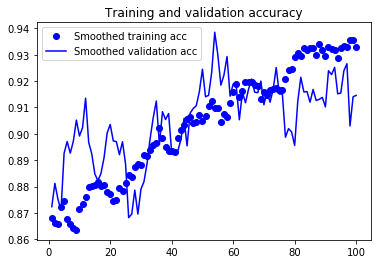

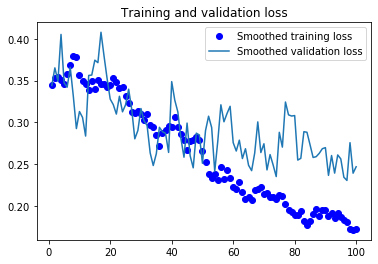

In [21]:
#Графики функции потерь и точности на стадиях обучения и валидации
#(для детекции переобучения)
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


acc = history.history['acc']
loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()